In [1]:
import torch 
import torch.nn as nn

import torch.nn.functional as F
import matplotlib.pylab as plt
import numpy as np

import os
import torch
from torch.utils.data import Dataset, DataLoader, random_split
# from PIL import Image
import torchvision.transforms as transforms
import pandas as pd

torch.manual_seed(2)

# https://www.kaggle.com/competitions/digit-recognizer/overview

In [2]:
train_df = pd.read_csv("train.csv")
labels = train_df['label'].values
pixels = train_df.drop(columns=['label']).values

class MNIST_train(Dataset):
    def __init__(self, pixels, labels):
        self.pixels = torch.tensor(pixels, dtype=torch.float32).view(-1, 1, 28, 28) / 255.0  # Normalize to [0, 1]
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.pixels[idx], self.labels[idx]


mnist_dataset = MNIST_train(pixels, labels)

In [3]:
train_size = int(0.80 * len(mnist_dataset))
val_size = len(mnist_dataset) - train_size

train_dataset, val_dataset = random_split(mnist_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True,drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, drop_last=True)

In [4]:
test_df = pd.read_csv("test.csv")
pixels = test_df.values

class MNIST_test(Dataset):
    def __init__(self, pixels):
        self.pixels = torch.tensor(pixels, dtype=torch.float32).view(-1, 1, 28, 28) / 255.0  # Normalize to [0, 1]

    def __len__(self):
        return len(test_df)

    def __getitem__(self, idx):
        return self.pixels[idx]

# Instantiate dataset
mnist_dataset_test = MNIST_test(pixels) # pixels ???

# Create DataLoader
test_loader = DataLoader(mnist_dataset_test, batch_size=64, shuffle=False, drop_last=False)

In [5]:
def train(model, criterion, train_loader, test_loader, optimizer, epochs=10):
    i = 0
    output = {'training_loss': [], 'test_accuracy': []}  
    
    for epoch in range(epochs):
        print(str(epoch) + " / " + str(epochs))
        for i, (image, pred) in enumerate(train_loader):
            optimizer.zero_grad()
            z = model(image)
            loss = criterion(z, pred)
            loss.backward()
            optimizer.step()
            output['training_loss'].append(loss.data.item())
    
    return output

In [6]:
class PaulNet(nn.Module):
    def __init__(self):
        super(PaulNet, self).__init__()

        self.conv1 = nn.Conv2d(1, 8, kernel_size=5, stride = 1, padding = 0)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.fc1 = nn.Linear(12*12*8, 56)
        self.fc2 = nn.Linear(56, 10)

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = self.pool1(out)
        out = out.view(-1, 12*12*8)

        out = F.relu(self.fc1(out))
        out = self.fc2(out)
        # out = F.softmax(out, dim=1)

        return out

In [7]:
import torch.optim as optim


learning_rate = 0.001
epochs = 100
model = PaulNet()

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

output=train(model, criterion, train_loader, test_loader, optimizer, epochs)

0 / 100
1 / 100
2 / 100
3 / 100
4 / 100
5 / 100
6 / 100
7 / 100
8 / 100
9 / 100
10 / 100
11 / 100
12 / 100
13 / 100
14 / 100
15 / 100
16 / 100
17 / 100
18 / 100
19 / 100
20 / 100
21 / 100
22 / 100
23 / 100
24 / 100
25 / 100
26 / 100
27 / 100
28 / 100
29 / 100
30 / 100
31 / 100
32 / 100
33 / 100
34 / 100
35 / 100
36 / 100
37 / 100
38 / 100
39 / 100
40 / 100
41 / 100
42 / 100
43 / 100
44 / 100
45 / 100
46 / 100
47 / 100
48 / 100
49 / 100
50 / 100
51 / 100
52 / 100
53 / 100
54 / 100
55 / 100
56 / 100
57 / 100
58 / 100
59 / 100
60 / 100
61 / 100
62 / 100
63 / 100
64 / 100
65 / 100
66 / 100
67 / 100
68 / 100
69 / 100
70 / 100
71 / 100
72 / 100
73 / 100
74 / 100
75 / 100
76 / 100
77 / 100
78 / 100
79 / 100
80 / 100
81 / 100
82 / 100
83 / 100
84 / 100
85 / 100
86 / 100
87 / 100
88 / 100
89 / 100
90 / 100
91 / 100
92 / 100
93 / 100
94 / 100
95 / 100
96 / 100
97 / 100
98 / 100
99 / 100


In [8]:
model.eval()


count = 0
for img, label in val_loader:
    for i in range(64):
        if model(img[i]).argmax() == label[i] :
            count = count+1
        
print(f"Success rate : {count/(len(val_loader)*64)}")

# 10 epoch   : 0.9788883587786259
# 20 epochs  : 0.9809160305343512
# 100 epochs : 0.9833015267175572
# 100 AdamW  : 0.9853291984732825

Success rate : 0.9849713740458015


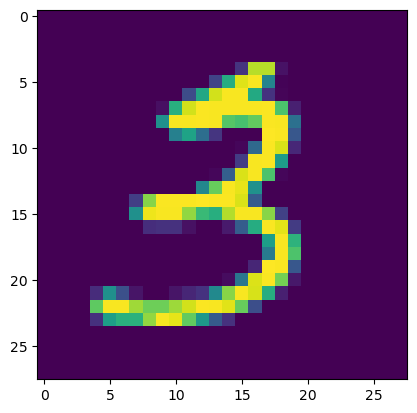

The image displays a 3


In [9]:
# running a small visual test

for img in test_loader:
    a = img
arr = a[1]
arr_ = np.squeeze(arr) # you can give axis attribute if you wanna squeeze in specific dimension
plt.imshow(arr_)
plt.show()
print("The image displays a " + str(model(a[1]).argmax().numpy()))

### Submission file creation

In [10]:
f = open("submission.csv", "a")
f.write("ImageId,Label\n")

i = 1
for x in test_loader:
    batch_pred = model(x)
    for elt in batch_pred:
        f.write(str(str(i) + "," + str(elt.argmax().numpy()) + "\n"))
        i = i + 1

f.close()
